**Initial Project setup**

* Import the libraries to be used throughout the project
* Load the training and testing data from the dataset
* Define the necessary functions for processing the images

In [1]:
#import the libraries used in the project
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras import regularizers
from PIL import Image
from tabulate import tabulate
import glob
import random

2024-06-03 07:28:47.837378: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 07:28:47.837506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 07:28:47.990832: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
np.random.seed(42)

In [5]:
# Function to load and preprocess images from a directory
def load_images_from_directory(directory, target_size=(128, 128), num_images=5):
    image_paths = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    images = []
    for path in image_paths:
        img = load_img(path, target_size=target_size)
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
    return np.array(images)

In [5]:
def plot_images(images, labels, title):
    plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=18, fontweight='bold')
    
    num_images = len(images)
    rows = (num_images + 4) // 5 
    
    for i, img in enumerate(images):
        plt.subplot(rows, 5, i + 1)
        plt.imshow(img)
        if labels[i] == 1:
            plt.title('Chihuahua')
        else:
            plt.title('Muffin')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [6]:
def plot_images_from_flow(images, labels, title):
    plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=18, fontweight='bold')

    num_images = len(images)
    rows = (num_images + 4) // 5

    for i, (img, label) in enumerate(zip(images, labels)):
        plt.subplot(rows, 5, i + 1)
        plt.imshow(img)
        if label[0] == 1:  # Check the first label in the array
            plt.title('Chihuahua')
        else:
            plt.title('Muffin')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [3]:
#Indicate the directories with the input images
test_data_path = '/kaggle/input/muffin-vs-chihuahua-image-classification/test'
train_data_path = '/kaggle/input/muffin-vs-chihuahua-image-classification/train'

train_chihuahuas_path = '/kaggle/input/muffin-vs-chihuahua-image-classification/train/chihuahua'
train_muffins_path = '/kaggle/input/muffin-vs-chihuahua-image-classification/train/muffin'

Use ImageDataGenerator to load images and generate augmented data for training the neural networks

In [6]:
# Load original images without augmentation
original_images_chihuahuas = load_images_from_directory('/kaggle/input/muffin-vs-chihuahua-image-classification/train/chihuahua')
original_images_muffins = load_images_from_directory('/kaggle/input/muffin-vs-chihuahua-image-classification/train/muffin')

# Combine original images into one dataset with labels
original_images = np.concatenate((original_images_chihuahuas, original_images_muffins))
original_labels = np.concatenate((np.ones(len(original_images_chihuahuas)), np.zeros(len(original_images_muffins))))

print("Shape of original images:", original_images.shape)
print("Shape of original labels:", original_labels.shape)

Shape of original images: (4733, 128, 128, 3)
Shape of original labels: (4733,)


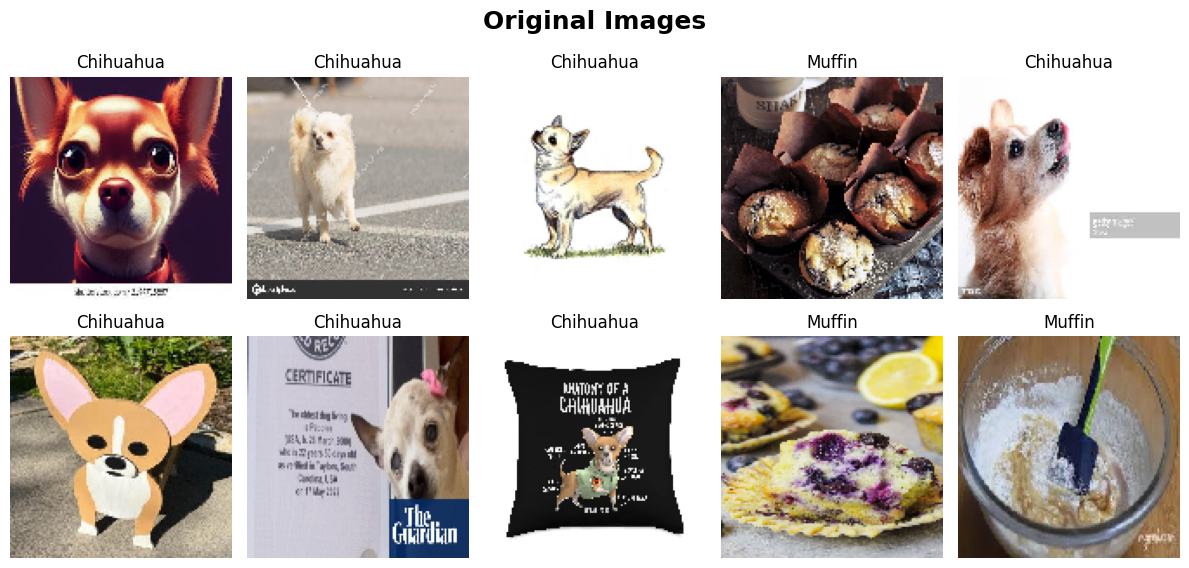

In [9]:
# Plot original images
# Randomly select 10 indices
num_samples = 10
total_images = len(original_images)
random_indices = np.random.choice(total_images, num_samples, replace=False)

# Select the images and labels at these random indices
random_images = original_images[random_indices]
random_labels = original_labels[random_indices]

# Plot the randomly selected images
plot_images(random_images, random_labels, "Original Images")

In [7]:
# Data augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Generate augmented images
augmented_images_generator = datagen.flow_from_directory(train_data_path,
                                                         target_size=(128, 128),
                                                         batch_size=4733,
                                                         shuffle=True)

test_images_generator = test_datagen.flow_from_directory(test_data_path,
                                                        target_size=(128, 128),
                                                        batch_size=1184,
                                                        shuffle=False)

augmented_images, augmented_labels = next(augmented_images_generator)
test_images, test_labels = next(test_images_generator)

print("Shape of augmented images array:", augmented_images.shape)
print("Shape of test images array:", test_images.shape)

Found 4733 images belonging to 2 classes.
Found 1184 images belonging to 2 classes.
Shape of augmented images array: (4733, 128, 128, 3)
Shape of test images array: (1184, 128, 128, 3)


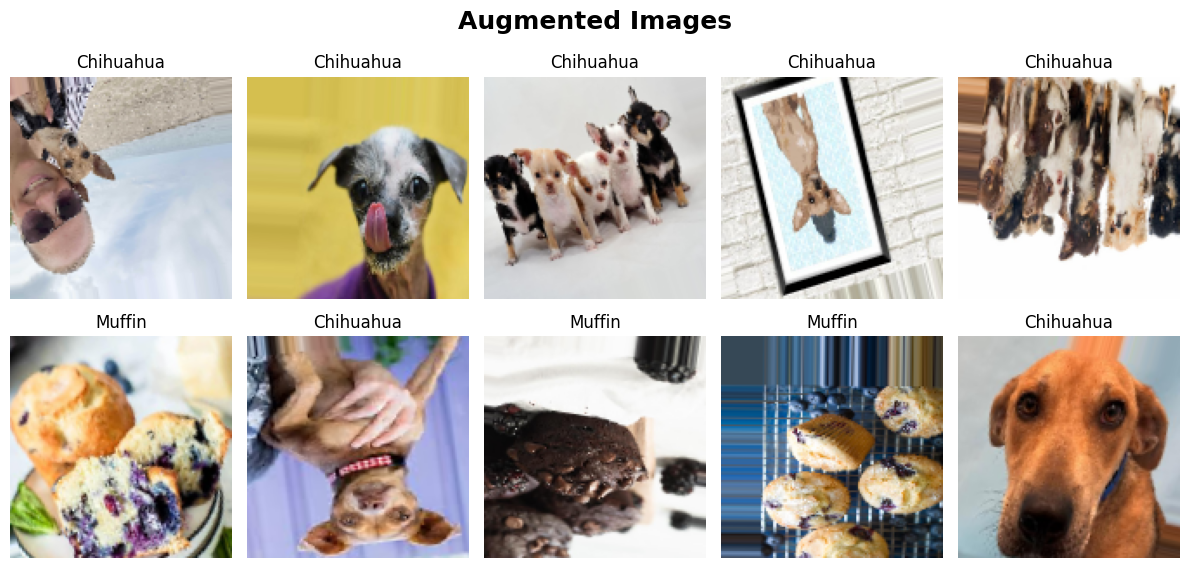

In [11]:
# Plot augmented images
# Choosing 10 images with the same random indeces selected before for preview
random_augmented_images = augmented_images[random_indices]
random_augmented_labels = augmented_labels[random_indices]
plot_images_from_flow(random_augmented_images, random_augmented_labels, "Augmented Images")

In [8]:
def plot_history(history):
    # Access training history
    training_loss = history.history['loss']
    training_accuracy = history.history['accuracy']
    validation_loss = history.history['val_loss']
    validation_accuracy = history.history['val_accuracy']

    # Plot training and validation loss
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy
    plt.plot(training_accuracy, label='Training Accuracy')
    plt.plot(validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [9]:
# Determine the total number of augmented samples
total_samples = augmented_images.shape[0]

In [10]:
# Define the validation split ratio
validation_split = 0.2

# Calculate the number of samples for validation
num_validation_samples = int(total_samples * validation_split)

In [11]:
# Split the augmented data into training and validation sets
X_train = augmented_images[:-num_validation_samples]
y_train = augmented_labels[:-num_validation_samples]
X_val = augmented_images[-num_validation_samples:]
y_val = augmented_labels[-num_validation_samples:]

In [16]:
# Ensure consistency in data shapes
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_train: (3787, 128, 128, 3)
Shape of y_train: (3787, 2)
Shape of X_val: (946, 128, 128, 3)
Shape of y_val: (946, 2)


In [17]:
print("Shape of test_images:", test_images.shape)
print("Shape of test_labels:", test_labels.shape)

Shape of test_images: (1184, 128, 128, 3)
Shape of test_labels: (1184, 2)


In [12]:
# Convert one-hot encoded labels to binary labels
y_train_binary = np.argmax(y_train, axis=1)
y_val_binary = np.argmax(y_val, axis=1)

# Ensure consistency in data shapes
print("Shape of y_train_binary:", y_train_binary.shape)
print("Shape of y_val_binary:", y_val_binary.shape)

Shape of y_train_binary: (3787,)
Shape of y_val_binary: (946,)


In [13]:
test_labels_binary = np.argmax(test_labels, axis=1)
print("Shape of test_labels_binary:", test_labels_binary.shape)

Shape of test_labels_binary: (1184,)


In [14]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

In [15]:
# Define ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [16]:
def create_history(model, number_of_epochs, batch_size, with_callback):
    if with_callback == True:
        history = model.fit(
        X_train,
        y_train_binary,
        epochs=number_of_epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val_binary),
        verbose=1,
        callbacks=[early_stopping, model_checkpoint]
        )
        return history
    else:
        history = model.fit(
            X_train,
            y_train_binary,
            epochs=number_of_epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val_binary),
            verbose=1,
        )
        return history

In [17]:
def print_model_results_table(model):
    results_training = model.evaluate(X_train, y_train_binary, verbose=0)
    results_validation = model.evaluate(X_val, y_val_binary, verbose=0)

    # Unpack the results
    train_loss, train_accuracy, train_precision, train_recall = results_training
    validation_loss, validation_accuracy, validation_precision, validation_recall = results_validation

    # Print the results
    results_dict = {
        'Metric': ['Loss', 'Accuracy', 'Precision', 'Recall'],
        'Training': [train_loss, train_accuracy, train_precision, train_recall],
        'Validation': [validation_loss, validation_accuracy, validation_precision, validation_recall]
    }

    results_df = pd.DataFrame(results_dict)
    table = tabulate(results_df, headers='keys', tablefmt='fancy_grid', stralign='center', numalign='center')

    # Print the formatted table
    print(table)

# Inital Model Development and tuning

In [24]:
model0 = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model0.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])
model0.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 127008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    16,257,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,258,177 (62.02 MB)

 Trainable params: 16,258,177 (62.02 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history0 = create_history(model0, 10, 32, False)

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 48s 384ms/step - accuracy: 0.6165 - loss: 1.5298 - precision: 0.5753 - recall: 0.5613 - val_accuracy: 0.7844 - val_loss: 0.4878 - val_precision: 0.7376 - val_recall: 0.8226
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 81s 375ms/step - accuracy: 0.8207 - loss: 0.4233 - precision: 0.8086 - recall: 0.8086 - val_accuracy: 0.7928 - val_loss: 0.4861 - val_precision: 0.7324 - val_recall: 0.8641
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 45s 382ms/step - accuracy: 0.8981 - loss: 0.2557 - precision: 0.8943 - recall: 0.8819 - val_accuracy: 0.7865 - val_loss: 0.4754 - val_precision: 0.8372 - val_recall: 0.6636
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 81s 377ms/step - accuracy: 0.9529 - loss: 0.1571 - precision: 0.9645 - recall: 0.9309 - val_accuracy: 0.7886 - val_loss: 0.6465 - val_precision: 0.7224 - val_recall: 0.8756
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 82s 377ms/step - accuracy: 0.9832 - loss: 0.0841 - precision: 0.9876 - recall: 0.9754 - val_accuracy: 0.8023

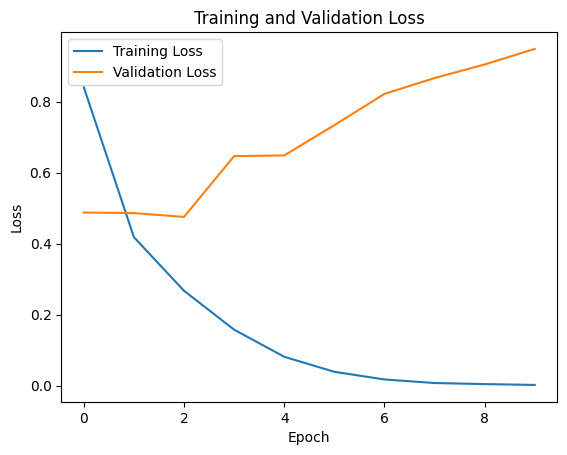

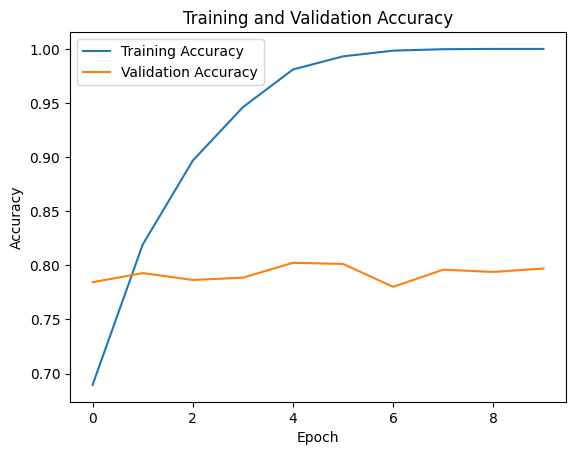

╒════╤═══════════╤════════════╤══════════════╕
│    │  Metric   │  Training  │  Validation  │
╞════╪═══════════╪════════════╪══════════════╡
│ 0  │   Loss    │ 0.00178648 │   0.948296   │
├────┼───────────┼────────────┼──────────────┤
│ 1  │ Accuracy  │     1      │   0.79704    │
├────┼───────────┼────────────┼──────────────┤
│ 2  │ Precision │     1      │   0.781395   │
├────┼───────────┼────────────┼──────────────┤
│ 3  │  Recall   │     1      │   0.774194   │
╘════╧═══════════╧════════════╧══════════════╛


In [26]:
plot_history(history0)
print_model_results_table(model0)

In [27]:
model1 = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    14,745,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,765,505 (56.33 MB)

 Trainable params: 14,765,505 (56.33 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history1 = create_history(model1, 10, 32, False)

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 65s 543ms/step - accuracy: 0.9972 - loss: 0.0123 - precision: 0.9951 - recall: 0.9990 - val_accuracy: 0.7928 - val_loss: 1.1746 - val_precision: 0.7705 - val_recall: 0.7811
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 66s 556ms/step - accuracy: 0.9962 - loss: 0.0182 - precision: 0.9951 - recall: 0.9966 - val_accuracy: 0.7886 - val_loss: 1.1773 - val_precision: 0.7511 - val_recall: 0.8065
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 66s 554ms/step - accuracy: 0.9949 - loss: 0.0199 - precision: 0.9928 - recall: 0.9963 - val_accuracy: 0.8044 - val_loss: 1.2443 - val_precision: 0.7588 - val_recall: 0.8410
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 80s 540ms/step - accuracy: 0.9991 - loss: 0.0050 - precision: 0.9980 - recall: 1.0000 - val_accuracy: 0.8066 - val_loss: 1.3215 - val_precision: 0.7808 - val_recall: 0.8041
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 66s 555ms/step - accuracy: 0.9998 - loss: 0.0027 - precision: 0.9998 - recall: 0.9998 - val_accuracy: 0.8087

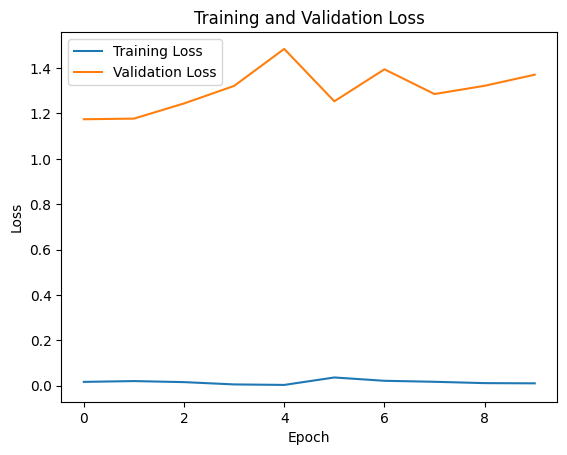

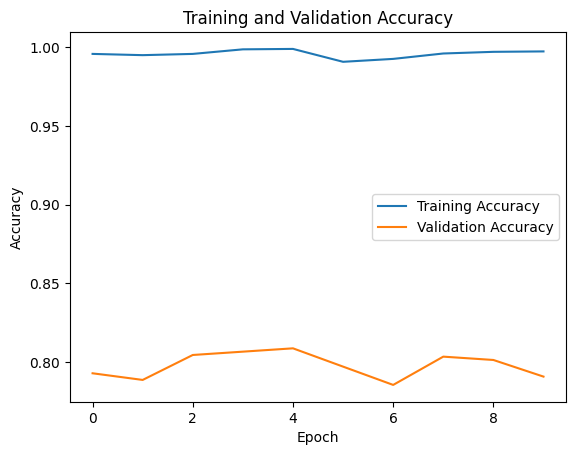

╒════╤═══════════╤════════════╤══════════════╕
│    │  Metric   │  Training  │  Validation  │
╞════╪═══════════╪════════════╪══════════════╡
│ 0  │   Loss    │ 0.0014119  │   1.37098    │
├────┼───────────┼────────────┼──────────────┤
│ 1  │ Accuracy  │  0.999736  │   0.790698   │
├────┼───────────┼────────────┼──────────────┤
│ 2  │ Precision │  0.999426  │   0.756522   │
├────┼───────────┼────────────┼──────────────┤
│ 3  │  Recall   │     1      │   0.801843   │
╘════╧═══════════╧════════════╧══════════════╛


In [31]:
plot_history(history1)
print_model_results_table(model1)

<!-- From the training results you provided, it seems like the model is indeed learning, as indicated by the increasing accuracy with each epoch. However, there are some indications of overfitting, which we can see from the fluctuating validation accuracy and loss.

Here's a breakdown of the key observations and potential adjustments:

Training Accuracy: The training accuracy increases steadily with each epoch, indicating that the model is fitting the training data well.

Validation Accuracy: The validation accuracy fluctuates, reaching a peak at certain epochs but not consistently improving. This suggests that the model's performance on unseen data is inconsistent and might be overfitting.

Training Loss: The training loss consistently decreases with each epoch, which is expected as the model learns to minimize its error on the training data.

Validation Loss: The validation loss fluctuates, showing peaks and valleys throughout training. This is a sign of overfitting, where the model is learning to fit noise in the training data rather than capturing general patterns.

To address these issues, here are some potential adjustments:

Regularization: Introduce techniques like dropout or L2 regularization to prevent overfitting. Dropout randomly sets a fraction of input units to zero during training, which helps prevent overfitting by forcing the model to learn more robust features. L2 regularization adds a penalty term to the loss function, discouraging large weights in the network.

Early Stopping: Use early stopping to halt training when the validation loss stops improving, thus preventing overfitting. This technique saves the model at the point where it performs best on the validation set.

Data Augmentation: If applicable, increase the diversity of the training data by applying transformations like rotation, scaling, or flipping to the images. This can help the model generalize better to unseen data.

Model Complexity: Consider reducing the model's capacity by decreasing the number of parameters or layers if overfitting persists. Sometimes, simpler models generalize better, especially with limited training data.

Implementing these adjustments and monitoring the training process should help improve the model's performance and reduce overfitting.
 -->

In [32]:
model2 = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,289 (24.86 MB)

 Trainable params: 6,516,289 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
history2 = create_history(model2, 10, 32, False)

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 69s 561ms/step - accuracy: 0.6135 - loss: 0.6908 - precision: 0.5898 - recall: 0.5538 - val_accuracy: 0.7199 - val_loss: 0.5423 - val_precision: 0.8118 - val_recall: 0.5069
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 81s 550ms/step - accuracy: 0.7915 - loss: 0.4869 - precision: 0.7766 - recall: 0.7515 - val_accuracy: 0.8277 - val_loss: 0.4234 - val_precision: 0.8159 - val_recall: 0.8065
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 82s 548ms/step - accuracy: 0.8126 - loss: 0.4099 - precision: 0.7980 - recall: 0.7981 - val_accuracy: 0.8319 - val_loss: 0.3908 - val_precision: 0.8747 - val_recall: 0.7396
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 65s 545ms/step - accuracy: 0.8479 - loss: 0.3552 - precision: 0.8264 - recall: 0.8299 - val_accuracy: 0.8383 - val_loss: 0.4090 - val_precision: 0.8727 - val_recall: 0.7581
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 81s 542ms/step - accuracy: 0.8440 - loss: 0.3474 - precision: 0.8334 - recall: 0.8438 - val_accuracy: 0.8414

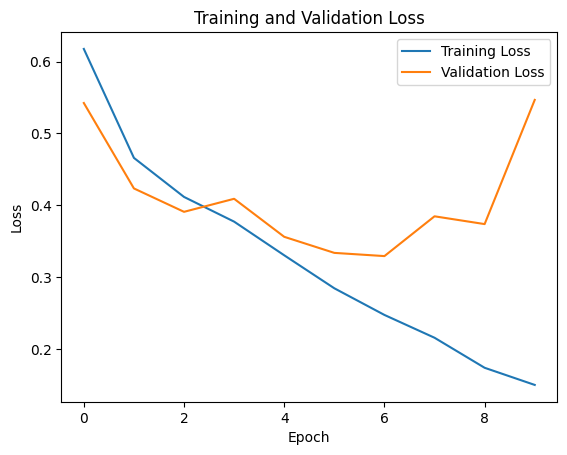

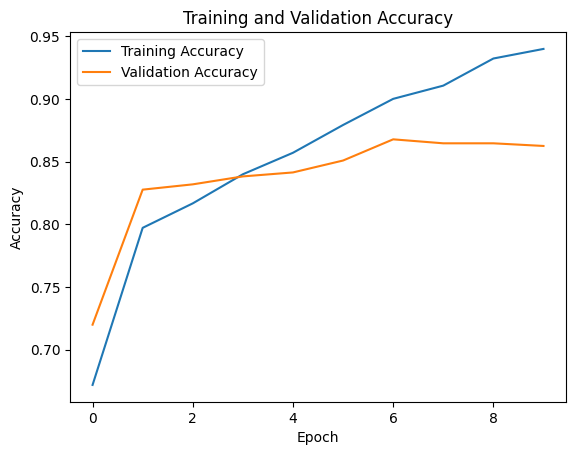

╒════╤═══════════╤════════════╤══════════════╕
│    │  Metric   │  Training  │  Validation  │
╞════╪═══════════╪════════════╪══════════════╡
│ 0  │   Loss    │  0.122424  │   0.546646   │
├────┼───────────┼────────────┼──────────────┤
│ 1  │ Accuracy  │  0.953525  │   0.862579   │
├────┼───────────┼────────────┼──────────────┤
│ 2  │ Precision │  0.972793  │   0.88191    │
├────┼───────────┼────────────┼──────────────┤
│ 3  │  Recall   │  0.924713  │   0.808756   │
╘════╧═══════════╧════════════╧══════════════╛


In [34]:
plot_history(history2)
print_model_results_table(model2)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,289 (24.86 MB)

 Trainable params: 6,516,289 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.5933 - loss: 0.6550 - precision: 0.5674 - recall: 0.5489
Epoch 1: val_accuracy improved from -inf to 0.76744, saving model to best_model.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 70s 568ms/step - accuracy: 0.5939 - loss: 0.6546 - precision: 0.5679 - recall: 0.5496 - val_accuracy: 0.7674 - val_loss: 0.5196 - val_precision: 0.7267 - val_recall: 0.8086
Epoch 2/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.7618 - loss: 0.5088 - precision: 0.7369 - recall: 0.7545
Epoch 2: val_accuracy did not improve from 0.76744
119/119 ━━━━━━━━━━━━━━━━━━━━ 67s 560ms/step - accuracy: 0.7619 - loss: 0.5086 - precision: 0.7371 - recall: 0.7546 - val_accuracy: 0.7283 - val_loss: 0.5627 - val_precision: 0.8848 - val_recall: 0.4842
Epoch 3/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.7759 - loss: 0.4719 - precision: 0.7592 - recall: 0.7361
Epoch 3: val_accuracy improved from 0.76744 to 0.81924, saving model to best_model.k

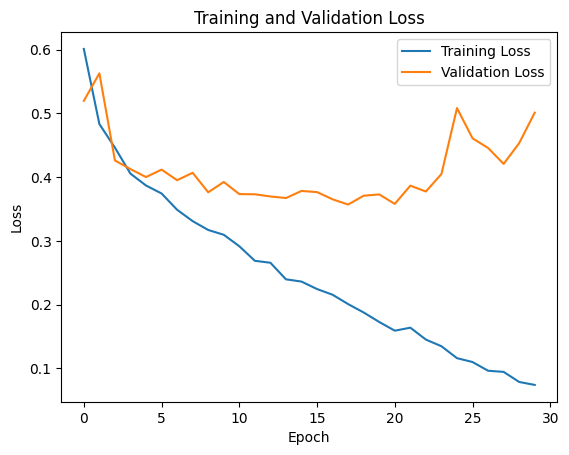

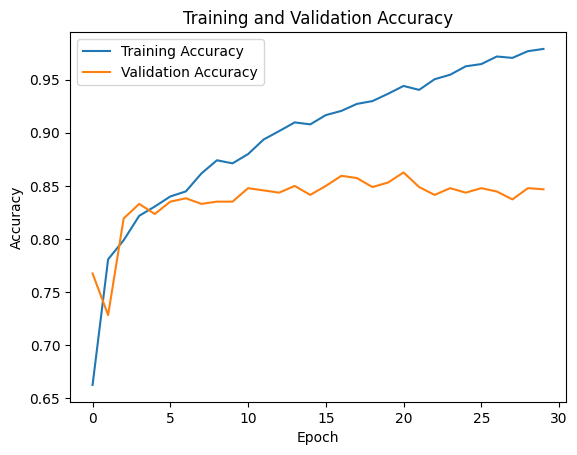

╒════╤═══════════╤════════════╤══════════════╕
│    │  Metric   │  Training  │  Validation  │
╞════╪═══════════╪════════════╪══════════════╡
│ 0  │   Loss    │ 0.0543719  │   0.501091   │
├────┼───────────┼────────────┼──────────────┤
│ 1  │ Accuracy  │  0.991286  │   0.846723   │
├────┼───────────┼────────────┼──────────────┤
│ 2  │ Precision │  0.996489  │   0.886305   │
├────┼───────────┼────────────┼──────────────┤
│ 3  │  Recall   │  0.984393  │   0.772523   │
╘════╧═══════════╧════════════╧══════════════╛


In [20]:
model3 = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])
model3.summary()
history3 = create_history(model3, 30, 32, True)
plot_history(history3)
print_model_results_table(model3)

# 5-Fold Cross Validation

In [18]:
from sklearn.model_selection import StratifiedKFold

In [19]:
def zero_one_loss(y_true, y_pred):
    y_pred_rounded = np.round(y_pred)
    return np.mean(np.abs(y_true - y_pred_rounded))

In [20]:
# Define the cross-validation function
def cross_validate_model(model, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_results = {'val_loss': [], 'val_accuracy': [], 'val_precision': [], 'val_recall': [], 'val_zero_one_loss': []}

    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        # Initialize a new model for each fold
        model_cv = tf.keras.models.clone_model(model)
        model_cv.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                         loss='binary_crossentropy',
                         metrics=['accuracy', 'precision', 'recall'])

        print(f"Training fold {fold}/{n_splits}...")
        history = model_cv.fit(X_train_fold, 
                               y_train_fold,
                               epochs=30, 
                               batch_size=32, 
                               verbose=1,
                               validation_data=(X_val_fold, y_val_fold))

        # Evaluate on validation fold
        val_loss, val_accuracy, val_precision, val_recall = model_cv.evaluate(X_val_fold, y_val_fold, verbose=1)
        
        # Predict on validation fold and calculate zero-one loss
        y_val_pred = model_cv.predict(X_val_fold)
        val_zero_one_loss = zero_one_loss(y_val_fold, y_val_pred)
        
        # Store results
        cv_results['val_loss'].append(val_loss)
        cv_results['val_accuracy'].append(val_accuracy)
        cv_results['val_precision'].append(val_precision)
        cv_results['val_recall'].append(val_recall)
        cv_results['val_zero_one_loss'].append(val_zero_one_loss)

    # Average results across folds
    avg_results = {metric: np.mean(values) for metric, values in cv_results.items()}
    return avg_results

In [24]:
cv_results_model3 = cross_validate_model(model3, X_train, y_train_binary)

Training fold 1/5...
Epoch 1/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 57s 576ms/step - accuracy: 0.6116 - loss: 0.6524 - precision: 0.5719 - recall: 0.4359 - val_accuracy: 0.7493 - val_loss: 0.5281 - val_precision: 0.7393 - val_recall: 0.6965
Epoch 2/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 53s 556ms/step - accuracy: 0.7549 - loss: 0.5197 - precision: 0.7433 - recall: 0.7237 - val_accuracy: 0.7612 - val_loss: 0.4878 - val_precision: 0.6854 - val_recall: 0.8815
Epoch 3/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 81s 548ms/step - accuracy: 0.7737 - loss: 0.4777 - precision: 0.7548 - recall: 0.7587 - val_accuracy: 0.8140 - val_loss: 0.4435 - val_precision: 0.8339 - val_recall: 0.7399
Epoch 4/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 560ms/step - accuracy: 0.8137 - loss: 0.4270 - precision: 0.7942 - recall: 0.7934 - val_accuracy: 0.8166 - val_loss: 0.4280 - val_precision: 0.8462 - val_recall: 0.7312
Epoch 5/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 53s 556ms/step - accuracy: 0.8234 - loss: 0.4022 - precision: 0.8080 - recall: 0.8072 - val_accur

In [25]:
print("Cross-Validation Results for Model 3:", cv_results_model3)

Cross-Validation Results for Model 3: {'val_loss': 0.4328097105026245, 'val_accuracy': 0.8505407691001892, 'val_precision': 0.8364791750907898, 'val_recall': 0.8450867056846618, 'val_zero_one_loss': 0.4969429241595186}


# Tuning

In [21]:
import keras_tuner as kt

In [22]:
def build_model(hp):
    model = Sequential([
        Input(shape=(128, 128, 3)),
        Conv2D(hp.Int('conv_1_filters', min_value=32, max_value=128, step=32), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(hp.Int('conv_2_filters', min_value=32, max_value=128, step=32), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(hp.Int('conv_3_filters', min_value=32, max_value=128, step=32), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'),
        Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.6, step=0.1)),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate = 0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'precision', 'recall'])
    
    return model

In [46]:
def run_tuning_and_save():
    tuner = kt.Hyperband(
        build_model,
        objective='val_accuracy',
        max_epochs=20,
        hyperband_iterations=2,
        directory='hyperband_dir',
        project_name='model3_tuning'
    )

    tuner.search(X_train, y_train_binary, epochs=15, validation_data=(X_val, y_val_binary))

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    print(tuner.results_summary())
    
    print(f"Optimal learning rate: {best_hps.get('learning_rate')}")
    print(f"Optimal conv_1_filters: {best_hps.get('conv_1_filters')}")
    print(f"Optimal conv_2_filters: {best_hps.get('conv_2_filters')}")
    print(f"Optimal conv_3_filters: {best_hps.get('conv_3_filters')}")
    print(f"Optimal dense_units: {best_hps.get('dense_units')}")
    print(f"Optimal dropout_rate: {best_hps.get('dropout_rate')}")

    tuned_model = tuner.hypermodel.build(best_hps)

    # Save the tuned model to the output directory
    tuned_model.save('/kaggle/outputs/tuned_model.h5')
    
    # Save the best hyperparameters to the output directory
    best_hps_dict = {
        'learning_rate': best_hps.get('learning_rate'),
        'conv_1_filters': best_hps.get('conv_1_filters'),
        'conv_2_filters': best_hps.get('conv_2_filters'),
        'conv_3_filters': best_hps.get('conv_3_filters'),
        'dense_units': best_hps.get('dense_units'),
        'dropout_rate': best_hps.get('dropout_rate')
    }

    with open('/kaggle/outputs/best_hyperparameters.json', 'w') as f:
        json.dump(best_hps_dict, f)
        
    tuned_history = create_history(tuned_model, 30, 32, True)

In [ ]:
run_tuning_and_save()

Trial 49 Complete [00h 13m 41s]
val_accuracy: 0.8498942852020264

Best val_accuracy So Far: 0.8900634050369263
Total elapsed time: 11h 27m 25s

Search: Running Trial #50

Value             |Best Value So Far |Hyperparameter
128               |128               |conv_1_filters
96                |96                |conv_2_filters
96                |128               |conv_3_filters
128               |64                |dense_units
0.3               |0.5               |dropout_rate
7                 |20                |tuner/epochs
0                 |7                 |tuner/initial_epoch
1                 |1                 |tuner/bracket
0                 |1                 |tuner/round

Epoch 1/7
 16/119 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - accuracy: 0.4857 - loss: 0.7041 - precision: 0.4419 - recall: 0.5397

In [ ]:
tuned_history = create_history(tuned_model, 30, 32, True)

In [37]:
tuner.search(X_train, y_train_binary, epochs=15, validation_split=0.2)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 24m 50s]
val_accuracy: 0.8456464409828186

Best val_accuracy So Far: 0.8733509182929993
Total elapsed time: 09h 23m 19s


In [23]:
tuned_model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(96, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [38]:
# tuned_model = Sequential([
#     Input(shape=(128, 128, 3)),
#     Conv2D(best_hps.get('conv_1_filters'), (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Conv2D(best_hps.get('conv_2_filters'), (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Conv2D(best_hps.get('conv_3_filters'), (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(best_hps.get('dense_units'), activation='relu'),
#     Dropout(best_hps.get('dropout_rate')),
#     Dense(1, activation='sigmoid')
# ])

In [24]:
def zero_one_l(y_true, y_pred):
    y_pred_rounded = tf.round(y_pred)
    y_true = tf.cast(y_true, tf.float32)
    return tf.reduce_mean(tf.abs(y_true - y_pred_rounded))

In [25]:
tuned_model.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='binary_crossentropy',
                    metrics=['accuracy', 'precision', 'recall', zero_one_l])

In [27]:
tuned_model.summary()
tuned_history = create_history(tuned_model, 30, 32, True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 96)     │       110,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,492,261 (20.95 MB)

 Trainable params: 1,830,753 (6.98 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,661,508 (13.97 MB)

Epoch 1/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5872 - loss: 0.6655 - precision: 0.5677 - recall: 0.3856 - zero_one_l: 0.4848
Epoch 1: val_accuracy improved from -inf to 0.73784, saving model to best_model.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.5875 - loss: 0.6653 - precision: 0.5679 - recall: 0.3868 - zero_one_l: 0.4849 - val_accuracy: 0.7378 - val_loss: 0.5622 - val_precision: 0.6976 - val_recall: 0.7793 - val_zero_one_l: 0.4945
Epoch 2/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7386 - loss: 0.5414 - precision: 0.7049 - recall: 0.7462 - zero_one_l: 0.4923
Epoch 2: val_accuracy improved from 0.73784 to 0.77061, saving model to best_model.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.7387 - loss: 0.5412 - precision: 0.7050 - recall: 0.7463 - zero_one_l: 0.4923 - val_accuracy: 0.7706 - val_loss: 0.4911 - val_precision: 0.8328 - val_recall: 0.6396 - val_zero_one_l: 0.4852
Epoch 3/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/s

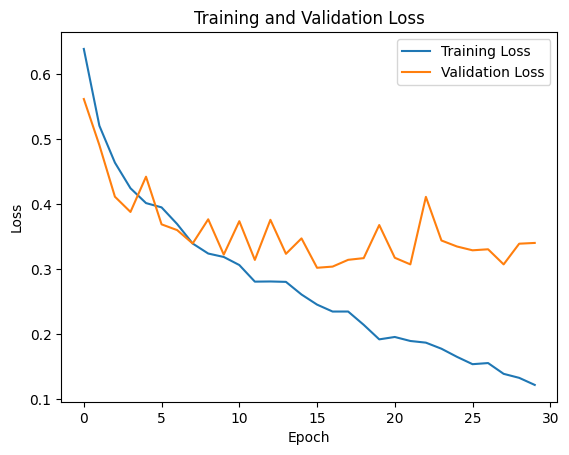

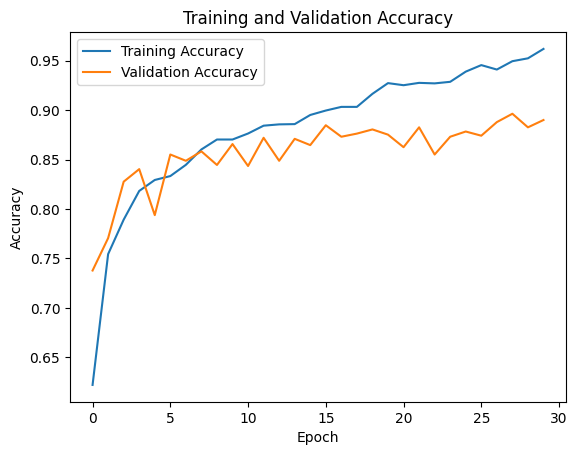

In [28]:
plot_history(tuned_history)

In [ ]:
cv_results_tuned_model = cross_validate_model(tuned_model, X_train, y_train_binary)

Training fold 1/5...
Epoch 1/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.6059 - loss: 0.6649 - precision: 0.6014 - recall: 0.2858 - val_accuracy: 0.7032 - val_loss: 0.5584 - val_precision: 0.6318 - val_recall: 0.8382
Epoch 2/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.7062 - loss: 0.5698 - precision: 0.6765 - recall: 0.7108 - val_accuracy: 0.7665 - val_loss: 0.4937 - val_precision: 0.7845 - val_recall: 0.6734
Epoch 3/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.7572 - loss: 0.5068 - precision: 0.7269 - recall: 0.7752 - val_accuracy: 0.8047 - val_loss: 0.4461 - val_precision: 0.7765 - val_recall: 0.8035
Epoch 4/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.8020 - loss: 0.4520 - precision: 0.7659 - recall: 0.8003 - val_accuracy: 0.8298 - val_loss: 0.3943 - val_precision: 0.7893 - val_recall: 0.8555
Epoch 5/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.8257 - loss: 0.4143 - precision: 0.8013 - recall: 0.8258 - val_accuracy: 0.821

In [32]:
test_loss, test_accuracy, test_precision, test_recall, test_zero_one_loss = tuned_model.evaluate(test_images, test_labels_binary, verbose=1)
print("\nTest Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test Zero one loss:", test_zero_one_loss)

37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 501ms/step - accuracy: 0.8778 - loss: 0.3123 - precision: 0.3373 - recall: 0.4355 - zero_one_l: 0.1222

Test Loss: 0.3270859718322754
Test Accuracy: 0.8826013803482056
Test Precision: 0.8558875322341919
Test Recall: 0.8952205777168274
Test Zero one loss: 0.11739864945411682
